# Enhanced LSB Steganography With Higher Data Concentration
Thisproject covers the basics of steganography and Basic Least Significant Bit Steganography (LSB) in images. We then show that we can further inceasethe amount of data we store in imags by using another layer of bits from the RGB Channels and hence aking this esssentially the 2 Least Significant Bits Steganography.

In [38]:
# loading in the required packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

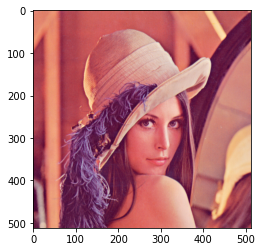

In [5]:
# loading in a standard image
J = cv2.imread('../assets/lenna.png')
I = cv2.cvtColor(J, cv2.COLOR_BGR2RGB)
plt.imshow(I)

Now, for the simple Least Significan Bit Steganography approach we need to take the Blue, Red and Green layers and then masure the amount of plaintex characters we can store there, considering that each character takes 8 bits.

In the below section we create functions for the novel method to see the data volume it can store.

In [6]:
def max_message_length(I: np.ndarray) -> int:
    return (get_image_volume_optimum(I) - get_image_data_volume_bit_len(I)) // 8


def get_image_data_volume_bit_len(I: np.ndarray) -> int:
    return int(np.ceil(np.log2(get_image_volume_optimum(I) / 8)))


def get_image_volume_optimum(I: np.ndarray) -> int:
    """:returns the number of bits of information we can store in an image"""
    return 2 * np.prod(I.shape)

In [8]:
# so for the above image, we can have the following data storage
number_of_bits_required_for_storing_the_len = get_image_data_volume_bit_len(I)
number_of_bits_for_data = get_image_volume_optimum(I) 
maximum_plaintext_length = max_message_length(I)
print('number of bits required for storing the length:', number_of_bits_required_for_storing_the_len)
print('number of bits for data:', number_of_bits_for_data)
print('maximum length of plaintext we can store in image:', maximum_plaintext_length)

number of bits required for storing the length: 18
number of bits for data: 1572864
maximum length of plaintext we can store in image: 196605


In [9]:
# We now take a plaintext message which we will add in our image
plaintext = 'hello world, we will attack a dawn'

## 1. Utility Functions
### 1.1 Converting from Integer to Binary

In [10]:
def int_to_bin(number: int, length=8) -> str:
    b = bin(number)[2:]
    return ('0' * (-len(b) % length)) + b

In [12]:
number = 78
print(int_to_bin(number))

01001110


In [13]:
number = 100
print(int_to_bin(number, length=10))

0001100100


### 1.2 Converting Binary To Integer

In [14]:
def bin_to_int(number: str) -> int:
    return int(number, base=2)

In [15]:
print(bin_to_int('001010111'))

87


In [16]:
print(bin_to_int('0001111111011'))

1019


### 1.3 Utility Function To Convert a text stream into a bit stream

In [17]:
def get_bit_stream_from_plaintext(plaintext: str) -> list:
    stream = []
    for letter in plaintext:
        letter_bin = int_to_bin(ord(letter))
        for bit in letter_bin:
            stream.append(bit)
    return stream

### 1.4 Utility Function To Add a bit stream to a Color Channel (For Steganography)

In [18]:
def add_bit_stream_to_color_channel(stream: list, C: list, start_point: int, position=7) -> None:
    for i, bit in enumerate(stream):
        pixel_bin = int_to_bin(C[i + start_point])
        pixel_bin = pixel_bin[0:position] + bit + pixel_bin[position + 1:]
        C[i + start_point] = bin_to_int(pixel_bin)

### 1.5 Utility Function To Extract RGBChannel from the Image

In [21]:
def get_channel_stream(I) -> list:
    B, R, G = np.ravel(I[:, :, 0]).tolist(), np.ravel(I[:, :, 2]).tolist(), np.ravel(I[:, :, 1]).tolist()
    return B + R + G

### 1.6 Utility Function for adding a plaintext message into the 2 least significant bits of an image

In [22]:
# We create functions to add the message in the bit stream of the image
def lsb_encrypt(I, plaintext: str):
    image_shape = I.shape[0:2]
    C = get_channel_stream(I)
    plaintext_len_bit_size = get_image_data_volume_bit_len(I)
    plaintext_len_bin = int_to_bin(len(plaintext), length=plaintext_len_bit_size)

    # adding length bits to the image
    for i in range(plaintext_len_bit_size):
        pixel_bin = int_to_bin(C[i])
        pixel_bin = pixel_bin[0:7] + plaintext_len_bin[i]
        C[i] = bin_to_int(pixel_bin)

    # creating bit stream from plaintext
    stream = get_bit_stream_from_plaintext(plaintext)

    # adding the plaintext stream to the channel stream
    add_bit_stream_to_color_channel(stream[:np.prod(I.shape) - plaintext_len_bit_size], C, start_point=plaintext_len_bit_size, position=7)
    add_bit_stream_to_color_channel(stream[(np.prod(I.shape) - plaintext_len_bit_size):], C, start_point=0, position=6)

    B, R, G = C[:len(C) // 3], C[len(C) // 3: 2 * len(C) // 3], C[2 * len(C) // 3:]
    B = np.array(B).reshape(image_shape)
    R = np.array(R).reshape(image_shape)
    G = np.array(G).reshape(image_shape)

    # Adding the pixel layers back to the Image
    I[:, :, 0] = B
    I[:, :, 2] = R
    I[:, :, 1] = G
    return I

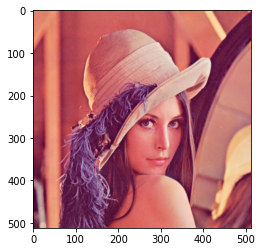

In [24]:
R = lsb_encrypt(I, plaintext)
plt.imshow(R)

### 1.6 Utility Function for Extracting the Significant Bits from the Channel Stream

In [28]:
def get_stream_from_channel(channel: list, position: int) -> list:
    stream = []
    for pixel in channel:
        pixel_bin = int_to_bin(pixel, length=8)
        pixel_bit = pixel_bin[position]
        stream.append(pixel_bit)
    return stream

### 1.7 Utility Function for Getting the Plaintext from the Bit Stream

In [32]:
def plaintext_from_bit_stream(stream: list) -> str:
    plaintext = ''
    for i in range(len(stream) // 8):
        byte = ''.join(stream[8 * i: 8 * i + 8])
        letter = bin_to_int(byte)
        plaintext += chr(letter)
    return plaintext

### 1.8 Utility Function for Extracting Plaintext Message from An Image
As we can see, adding the plaintext message doesn't make any visual change to the image that is perceptible to the naked guy. We now create a utility function to extract the plaintext message from the image.

In [33]:
def lsb_decrypt(I) -> str:
    # Obtaining the B G R channel stream
    C = get_channel_stream(I)
    plaintext_len_bit_size = get_image_data_volume_bit_len(I)
    plaintext_len_bin = ''.join([int_to_bin(C[i])[7] for i in range(plaintext_len_bit_size)])
    plaintext_len = bin_to_int(plaintext_len_bin)

    # creating the bit stream from the plaintext_len
    stream = get_stream_from_channel(channel=C, position=7) + get_stream_from_channel(channel=C, position=6)
    stream = stream[plaintext_len_bit_size:plaintext_len_bit_size + plaintext_len * 8]

    # creating plaintext from bit stream
    plaintext = plaintext_from_bit_stream(stream)
    return plaintext

In [35]:
message = lsb_decrypt(R)
print('decrypted', message)

decrypted hello world, we will attack a dawn


## Adding a huge (Maximum) Quantity of Data into the Image 
We see above that using the `lsb_encrypt()` and `lsb_decrypt()` methods we can use steganography to add textual data in any imae and then extract it. We ow try and add the maximum amount of data possible and then see whether hidig that will be possible, to test our hypothesistaht we canincrease the amount of data stored in an image, namely by 2 fold almost and also that adding so much data makes no perceivable difference to the Image.

In [36]:
# utility function to get a random string of arbitrary size
def random_string(length=8):
    return ''.join([chr(random.randint(0, 127)) for _ in range(length)])

In [39]:
plaintext = random_string(max_message_length(I))

storing this data in the image and extracting it using our utility functions `lsb_encrypt` and `lsb_decrypt`

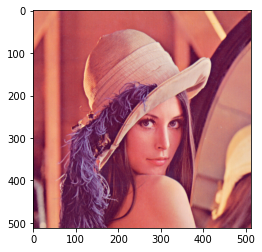

In [41]:
J = lsb_encrypt(I, plaintext)
decrypted = lsb_decrypt(J)
# the encrypted image is
plt.imshow(J)

In [42]:
# did we correctly extract the data?
print(decrypted == plaintext)

True


So, this proves that uing this enhanced version of LSB we can store twice the data of LSB without it being perceivable to the naked eye at all.

We also see below the difference between the original Image and the Image with the data.